## 1. **Import Required Libraries**

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import missingno as msno
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

from sklearn.model_selection import train_test_split

## 2. **Get Data**

### 2.1 **Load datasets**

In [2]:
# Load application record and credit record data into DataFrames
cc_application_df = pd.read_csv('data/application_record.csv')
cc_status_df = pd.read_csv('data/credit_record.csv')

### 2.2. **Create target variable**

In [3]:
# Determine how long each person has held their credit card
cc_duration = cc_status_df.groupby("ID")["MONTHS_BALANCE"].min().reset_index().rename(columns={"MONTHS_BALANCE": "account_age_(months)"})
cc_application_df = pd.merge(cc_application_df, cc_duration, how="left", on="ID")

# Create a new column 'is_risky' that identifies if the STATUS is considered risky (values 2, 3, 4, or 5)
cc_status_df['is_risky'] = np.where(cc_status_df['STATUS'].isin(['2', '3', '4', '5']), 'Yes', 'No')

# Determine if a person has ever defaulted, with Yes mapped to 1 and No mapped to 0
cc_defaulter = cc_status_df.groupby('ID')['is_risky'].max().reset_index()
cc_defaulter['is_risky'] = cc_defaulter['is_risky'].map({'Yes': 1, 'No': 0})
cc_application_df = pd.merge(cc_application_df, cc_defaulter, how='inner', on='ID')

# Ensure duration is positive and convert it to integer type for consistent data handling
cc_application_df['account_age_(months)'] = np.abs(cc_application_df['account_age_(months)']).astype('int64')

### 2.3 **Rename features**

In [4]:
# Define a mapping to rename DataFrame columns for clarity and consistency
column_rename_map = {
    'CODE_GENDER': 'gender',
    'FLAG_OWN_CAR': 'owns_car',
    'FLAG_OWN_REALTY': 'owns_property',
    'CNT_CHILDREN': 'child_count',
    'AMT_INCOME_TOTAL': 'annual_income',
    'NAME_INCOME_TYPE': 'occupation',
    'NAME_EDUCATION_TYPE': 'education',
    'NAME_FAMILY_STATUS': 'marital_status',
    'NAME_HOUSING_TYPE': 'accommodation',
    'DAYS_BIRTH': 'days_lived',
    'DAYS_EMPLOYED': 'employment_duration',
    'FLAG_MOBIL': 'has_mobile',
    'FLAG_WORK_PHONE': 'has_work_phone',
    'FLAG_PHONE': 'has_phone',
    'FLAG_EMAIL': 'has_email',
    'OCCUPATION_TYPE': 'job_title',
    'CNT_FAM_MEMBERS': 'family_size'
}
cc_application_df.rename(columns=column_rename_map, inplace=True)

### 2.4. **Split data**

In [5]:
# DataFrame before splitting data
final_df = cc_application_df.drop(columns=['ID'])

# Split the data into train and test sets
def data_split(df, size):
    train_df, test_df = train_test_split(df, test_size=size, random_state=42)
    return train_df.reset_index(drop=True), test_df.reset_index(drop=True)

cc_train_original, cc_test_original = data_split(final_df, 0.2)

## 3. **Exploratory Data Analysis (EDA)**

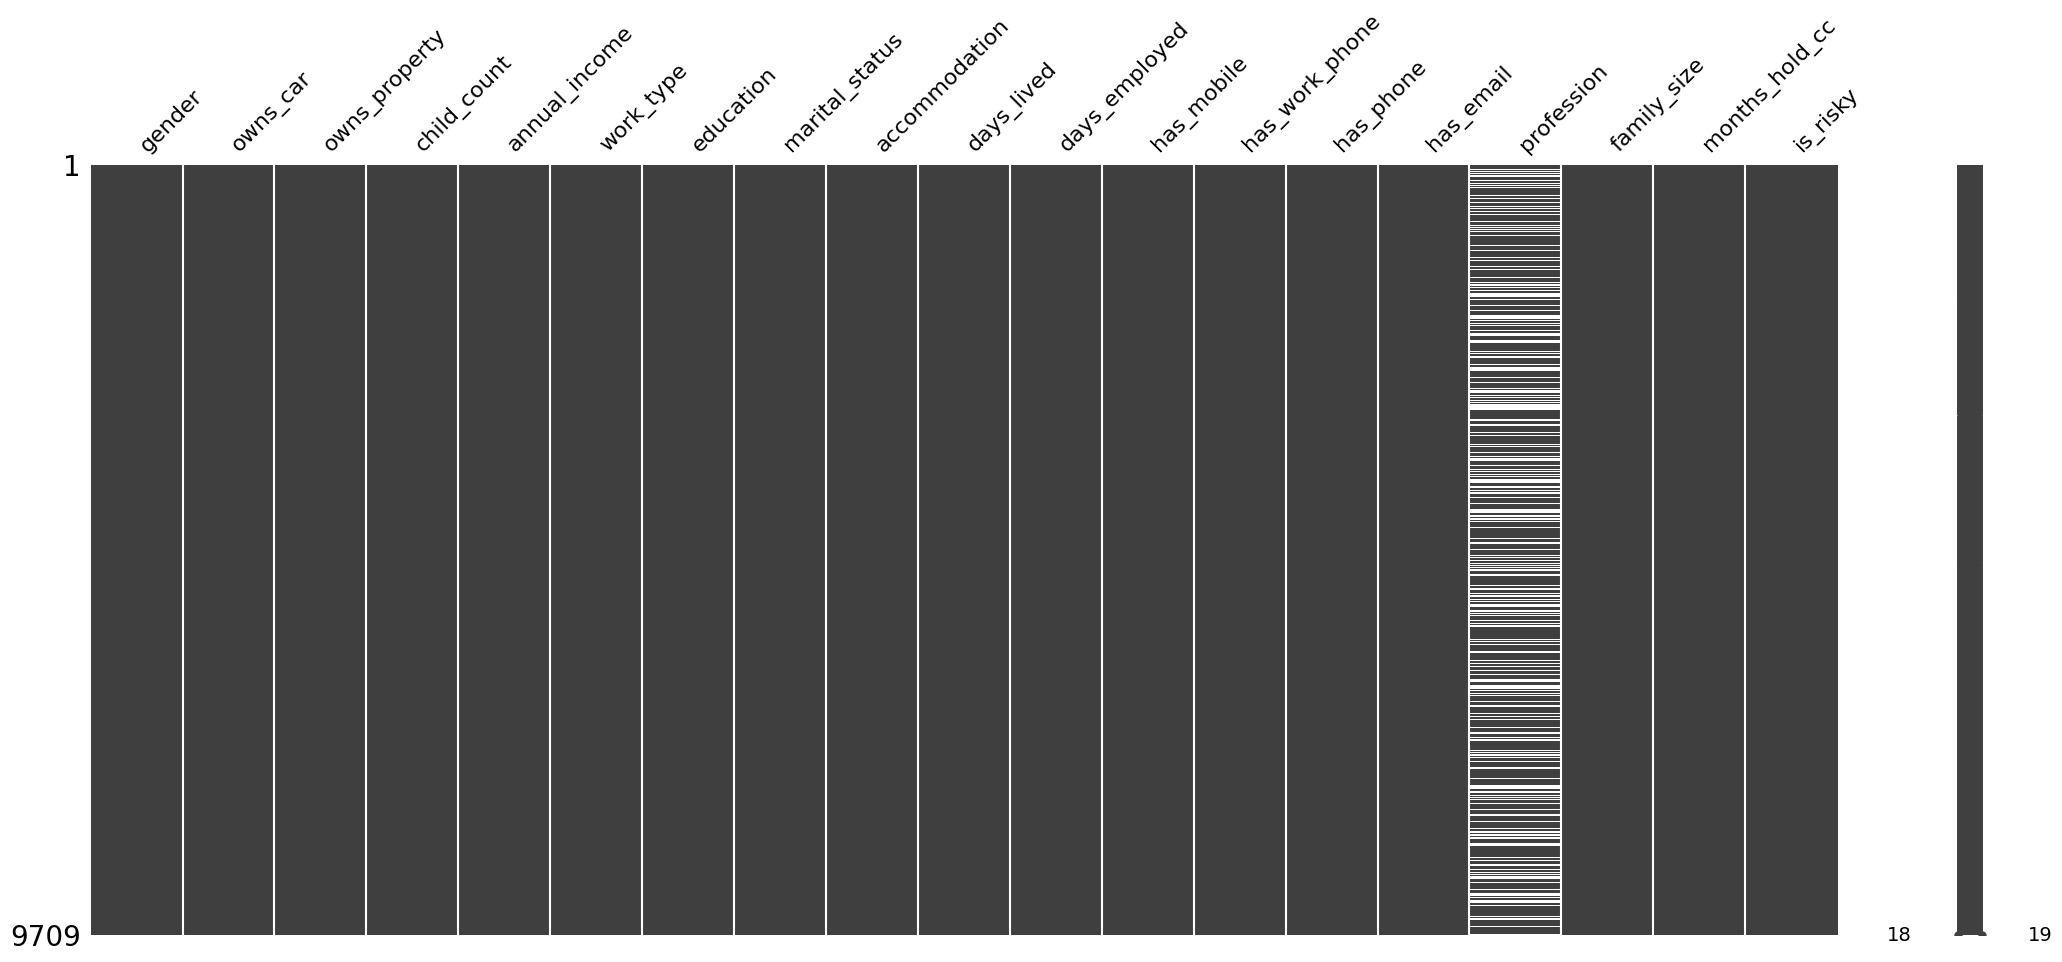

In [6]:
msno.matrix(final_df)
plt.show()

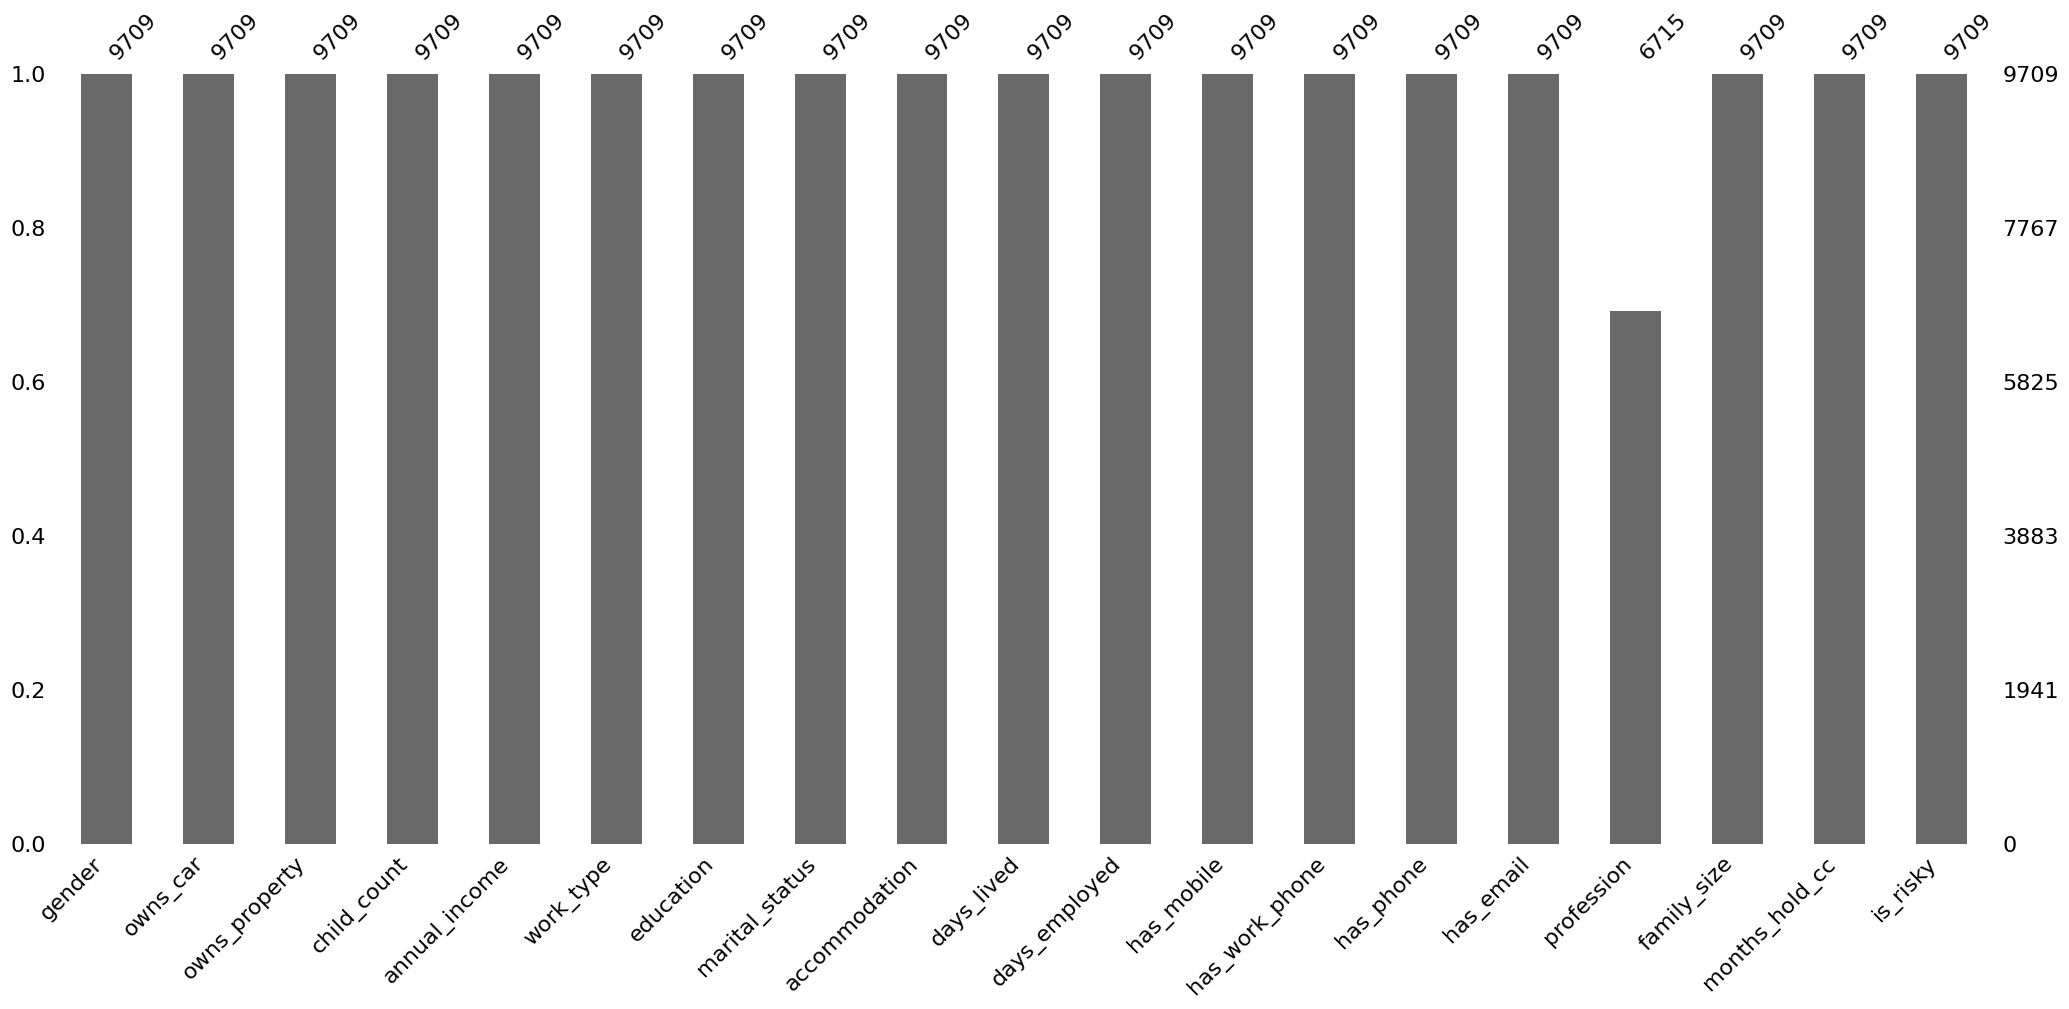

In [7]:
msno.bar(final_df)
plt.show()

In [8]:
# Create a copy of the dataset so that the original stays untouched
cc_train_copy = cc_train_original.copy()
cc_test_copy = cc_test_original.copy()

In [9]:
#Function that will return the count and frequency of each observation within a feature
def value_cnt_norm_cal(df,feature):
    ftr_value_cnt = df[feature].value_counts()
    ftr_value_cnt_norm = df[feature].value_counts(normalize=True) * 100
    ftr_value_cnt_concat = pd.concat([ftr_value_cnt, ftr_value_cnt_norm], axis=1)
    ftr_value_cnt_concat.columns = ['Count', 'Frequency (%)']
    return ftr_value_cnt_concat

In [10]:
# Function to create display general information about the feature
def gen_info_feat(df,feature):
    match feature:
        case 'days_lived':
            print('Description:\n{}'.format((np.abs(df[feature])/365.25).describe()))
            print('*'*50)
            print('Data type: {}'.format(df[feature].dtype))

        case 'annual_income':
            pd.set_option('display.float_format', lambda x: '%.2f' % x)
            print('Description:\n{}'.format(df[feature].describe()))
            print('*'*50)
            print('Data type: {}'.format(df[feature].dtype))

        case 'employment_duration':
            employed_non_retired = df[feature][df[feature] < 0]
            non_retired_years = np.abs(employed_non_retired) / 365.25
            print('Description (Years):\n{}'.format((non_retired_years).describe()))
            print('*'*50)
            print('Data type:{}'.format(df[feature].dtype))

        case 'account_age_(months)':
            pd.set_option('display.float_format', lambda x: '%.2f' % x)
            print('Description:\n{}'.format(df[feature].describe()))
            print('*'*50)
            print('Data type: {}'.format(df[feature].dtype))

        case _:
            print('Description:\n{}'.format(df[feature].describe()))
            print('*'*50)
            print('Data type: {}'.format(df[feature].dtype))
            print('*'*50)
            value_cnt = value_cnt_norm_cal(df,feature)
            print('{}'.format(value_cnt))

In [11]:
# Function to create a bar chart plot
def create_bar_plot(df, feature):
    value_counts = df[feature].value_counts()
    
    sns.barplot(x=value_counts.index, y=value_counts.values)
    plt.xlabel(f"{feature.replace('_', ' ').title()}", )
    plt.xticks(rotation=90)        
    plt.ylabel("Count")
    plt.title("Bar Chart")
    plt.show()

In [12]:
# Function to create a pie chart plot
def create_pie_plot(df, feature):
    value_counts = df[feature].value_counts(normalize=True) * 100
    
    match feature:                
        case 'accommodation':
            explode = [0, 0.05, 0.15, 0.3, 0.5, 0.7]
            colors = sns.color_palette('Set3')
            plt.pie(value_counts, labels=value_counts.index, autopct='%1.2f%%', startangle=270, explode=explode, colors=colors)
        
        case 'education':
            explode = [0, 0.05, 0.15, 0.3, 0.5]
            plt.pie(value_counts, labels=value_counts.index, autopct='%1.2f%%', startangle=45, explode=explode)

        case _:
            plt.pie(value_counts, labels=value_counts.index, autopct='%1.2f%%')
        
    plt.title("Pie Chart")
    plt.show()

In [13]:
# Function to create a histogram plot
def create_hist_plot(df, feature):
    match feature:
        case 'days_lived':
            sns.histplot(np.abs(df[feature]) / 365.25, bins=50, kde=True)
            plt.xlabel('Age (Years)')
        
        case 'annual_income':
            income_formatter = lambda x, _: f'{int(x / 100000)}'
            sns.histplot(df[feature], bins=50, kde=True)
            plt.gca().get_xaxis().set_major_formatter(mtick.FuncFormatter(income_formatter))
            plt.xlabel('Annual Income (Lakh)')
        
        case 'employment_duration':
            employed_non_retired = df[feature][df[feature] < 0]
            non_retired_years = np.abs(employed_non_retired) / 365.25
            sns.histplot(non_retired_years, bins=50, kde=True)
            plt.xlabel("Employment Duration (Years)")

        case _:
            sns.histplot(df[feature], bins=50, kde=True)
            plt.xlabel(feature.replace('_', ' ').title())
            
    plt.title("Histogram")
    plt.ylabel("Count")
    plt.show()

In [14]:
# Function to create a Boxplot
def create_boxplot(df, feature):
    match feature:
        case 'days_lived':
            sns.boxplot(y=np.abs(df[feature]) / 365.25)
            plt.ylabel('Age (Years)')

        case 'annual_income':
            income_formatter = lambda x, _: f'{int(x / 100000)}'
            ax = sns.boxplot(y=df[feature])
            ax.get_yaxis().set_major_formatter(mtick.FuncFormatter(income_formatter))
            plt.ylabel('Annual Income (Lakh)')

        case 'employment_duration':
            employed_non_retired = df[feature][df[feature] < 0]
            non_retired_years = np.abs(employed_non_retired) / 365.25
            sns.boxplot(y=non_retired_years)
            plt.ylabel("Employment Duration (Years)")

        case _:
            sns.boxplot(y=df[feature])
            plt.ylabel(feature.replace("_", " ").title())
    
    plt.title("Box Plot")
    plt.show()

In [15]:
# Function to create a Low/High Risk Boxplot
def low_high_risk_boxplot(df, feature):
    match feature:
        case 'days_lived':
            df['Age (Years)'] = np.abs(df[feature]) / 365.25
            sns.boxplot(x=df['is_risky'], y=df['Age (Years)'])
            plt.ylabel('Age (Years)')
        
        case 'annual_income':
            ax = sns.boxplot(x=df['is_risky'], y=df[feature])
            ax.get_yaxis().set_major_formatter(mtick.FuncFormatter(lambda x, _: f'{int(x / 100000)}'))
            plt.ylabel('Annual Income (Lakh)')

        case 'employment_duration':
            employed_non_retired = df[feature][df[feature] < 0]
            non_retired_years = np.abs(employed_non_retired) / 365.25
            sns.boxplot(x=df['is_risky'], y=non_retired_years)
            plt.ylabel("Employment Duration (Years)")
            
        case _:
            sns.boxplot(x=df['is_risky'], y=df[feature])
            plt.ylabel(feature.replace("_", " ").title())
                
    plt.title("Low & High Risk Individuals - Box Plot")
    plt.xlabel('Risk')
    plt.xticks(ticks=[0, 1], labels=["Low", "High"])
    plt.show()

In [16]:
# Function to create a Low/High Risk Barplot
def low_high_risk_barplot(df, feature):
    aggregated_data = df.groupby(feature)['is_risky'].sum().sort_values(ascending=False)
    sns.barplot(x=aggregated_data.index, y=aggregated_data.values)
    plt.title("Low & High Risk Individuals - Bar Chart")
    plt.xlabel(feature.replace("_", " ").title())
    plt.xticks(rotation=90)        
    plt.ylabel('Count')
    plt.show()

### 3.1 **Gender**

In [17]:
gen_info_feat(cc_train_copy, 'gender')

Description:
count     7767
unique       2
top          F
freq      5029
Name: gender, dtype: object
**************************************************
Data type: object
**************************************************
        Count  Frequency (%)
gender                      
F        5029      64.748294
M        2738      35.251706


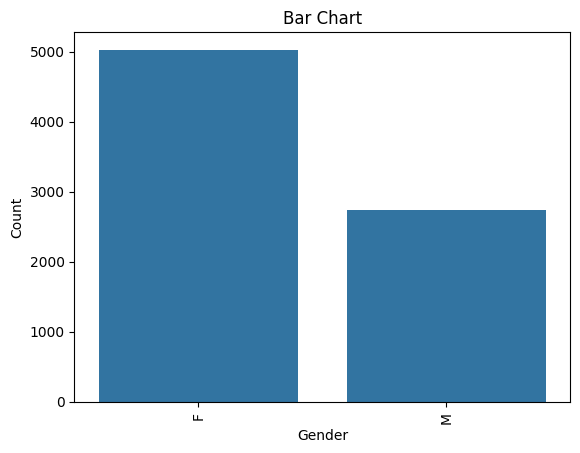

In [18]:
create_bar_plot(cc_train_copy, 'gender')

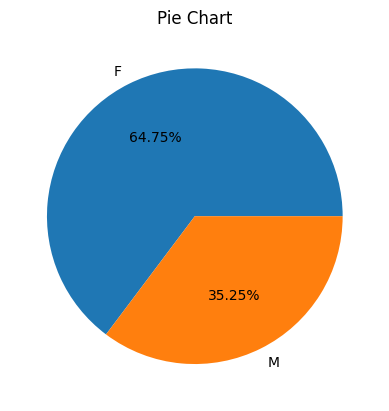

In [19]:
create_pie_plot(cc_train_copy, 'gender')

### 3.2 **Age**

In [20]:
gen_info_feat(cc_train_copy, 'days_lived')

Description:
count    7767.000000
mean       43.822532
std        11.593486
min        21.095140
25%        34.083504
50%        42.787132
75%        53.564682
max        68.862423
Name: days_lived, dtype: float64
**************************************************
Data type: int64


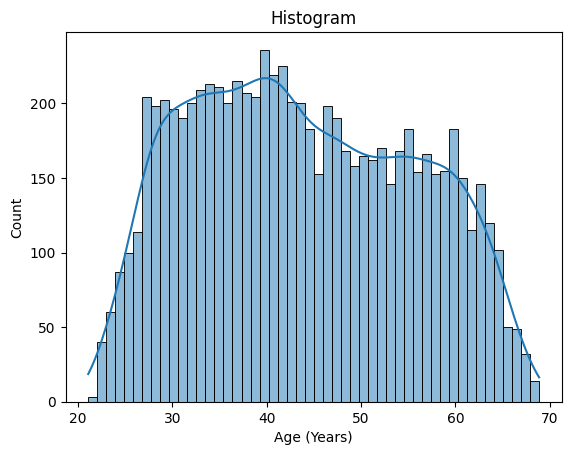

In [21]:
create_hist_plot(cc_train_copy, 'days_lived')

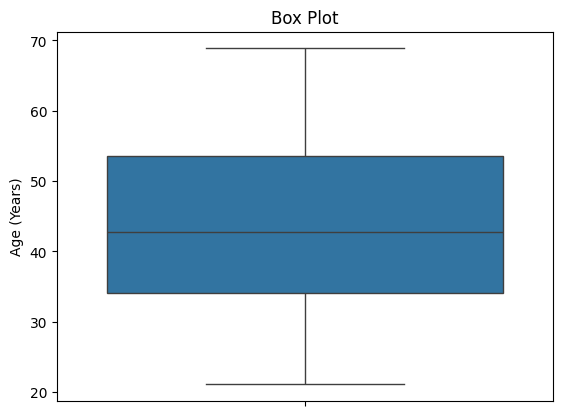

In [22]:
create_boxplot(cc_train_copy, 'days_lived')

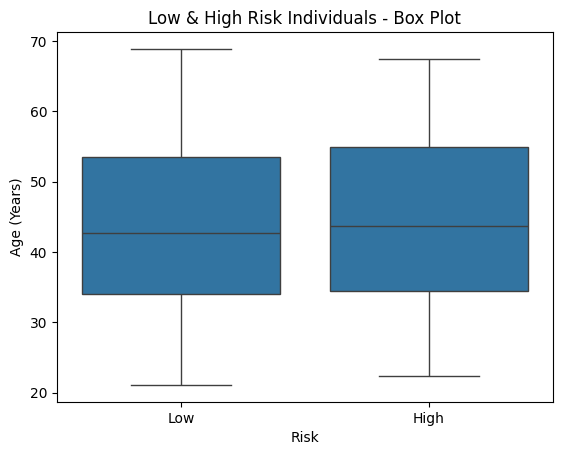

In [23]:
low_high_risk_boxplot(cc_train_copy, 'days_lived')

### 3.3 **Marital Status**

In [24]:
gen_info_feat(cc_train_copy, 'marital_status')

Description:
count        7767
unique          5
top       Married
freq         5227
Name: marital_status, dtype: object
**************************************************
Data type: object
**************************************************
                      Count  Frequency (%)
marital_status                            
Married                5227      67.297541
Single / not married   1088      14.007982
Civil marriage          666       8.574739
Separated               457       5.883868
Widow                   329       4.235870


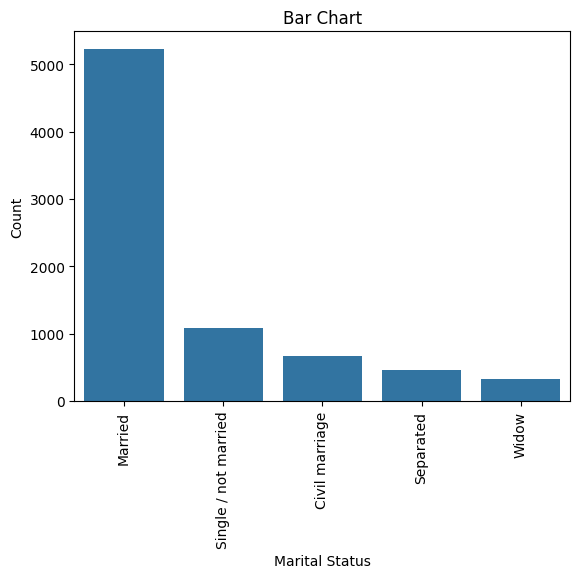

In [25]:
create_bar_plot(cc_train_copy, 'marital_status')

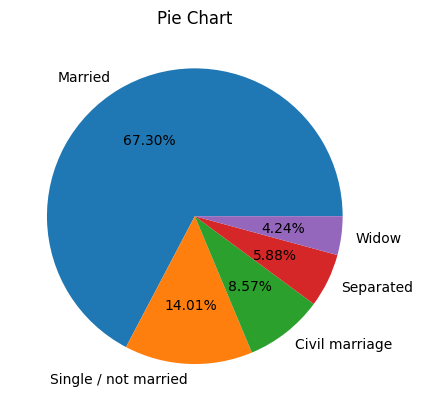

In [26]:
create_pie_plot(cc_train_copy, 'marital_status')

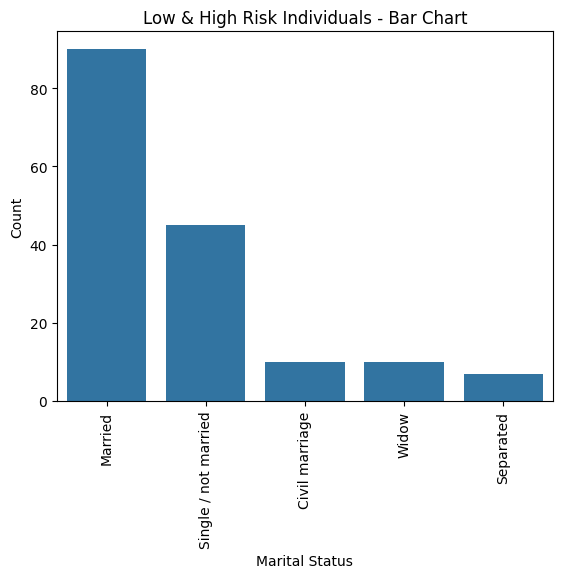

In [27]:
low_high_risk_barplot(cc_train_copy, 'marital_status')

### 3.4 **Family Size**

In [28]:
gen_info_feat(cc_train_copy, 'family_size')

Description:
count    7767.000000
mean        2.184241
std         0.942279
min         1.000000
25%         2.000000
50%         2.000000
75%         3.000000
max        20.000000
Name: family_size, dtype: float64
**************************************************
Data type: float64
**************************************************
             Count  Frequency (%)
family_size                      
2.0           4147      53.392558
1.0           1559      20.072100
3.0           1297      16.698854
4.0            650       8.368740
5.0             93       1.197374
6.0             14       0.180250
7.0              4       0.051500
15.0             1       0.012875
9.0              1       0.012875
20.0             1       0.012875


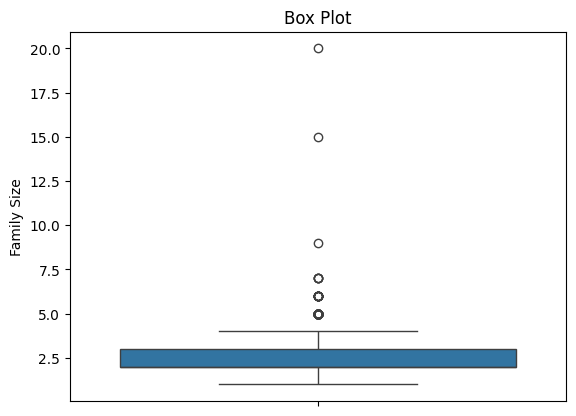

In [29]:
create_boxplot(cc_train_copy, 'family_size')

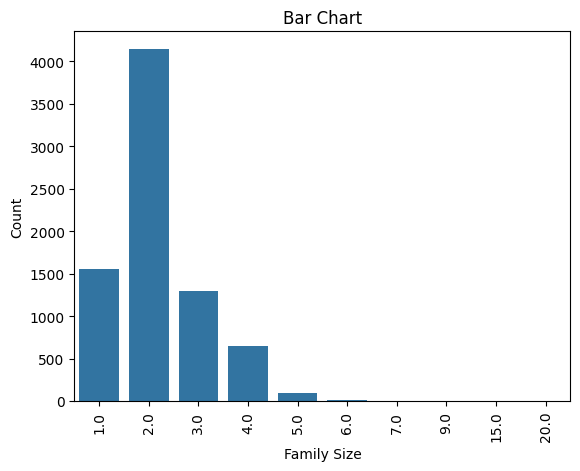

In [30]:
create_bar_plot(cc_train_copy, 'family_size')

### 3.5 **Children Count**

In [31]:
gen_info_feat(cc_train_copy, 'child_count')

Description:
count    7767.000000
mean        0.423716
std         0.778985
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max        19.000000
Name: child_count, dtype: float64
**************************************************
Data type: int64
**************************************************
             Count  Frequency (%)
child_count                      
0             5466      70.374662
1             1488      19.157976
2              691       8.896614
3              100       1.287498
4               14       0.180250
5                5       0.064375
14               1       0.012875
7                1       0.012875
19               1       0.012875


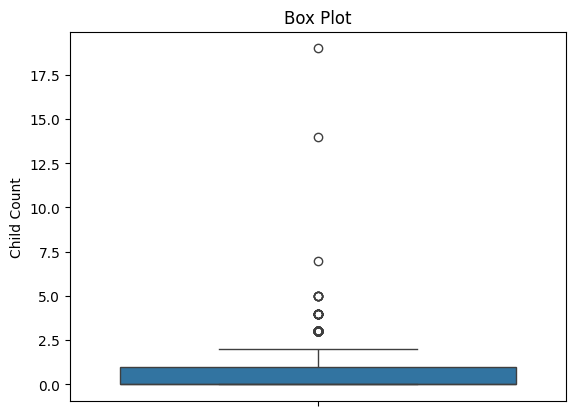

In [32]:
create_boxplot(cc_train_copy, 'child_count')

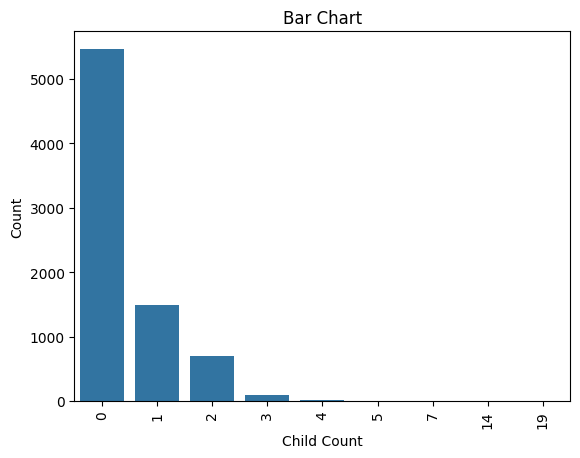

In [33]:
create_bar_plot(cc_train_copy, 'child_count')

### 3.6 **Accommodation**

In [34]:
gen_info_feat(cc_train_copy, 'accommodation')

Description:
count                  7767
unique                    6
top       House / apartment
freq                   6939
Name: accommodation, dtype: object
**************************************************
Data type: object
**************************************************
                     Count  Frequency (%)
accommodation                            
House / apartment     6939      89.339513
With parents           357       4.596369
Municipal apartment    271       3.489121
Rented apartment       113       1.454873
Office apartment        64       0.823999
Co-op apartment         23       0.296125


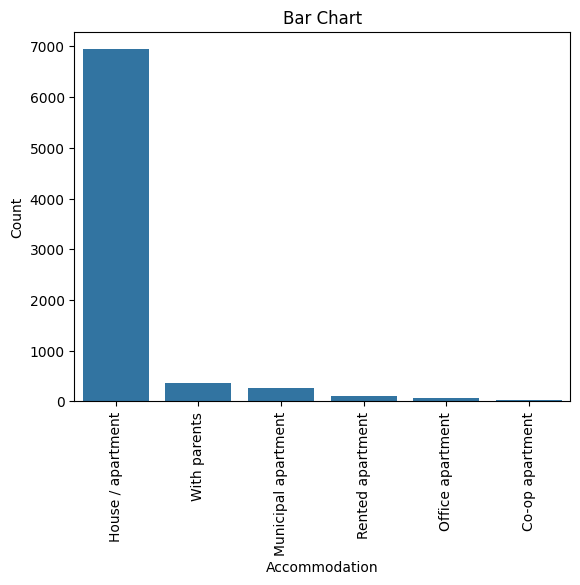

In [35]:
create_bar_plot(cc_train_copy, 'accommodation')

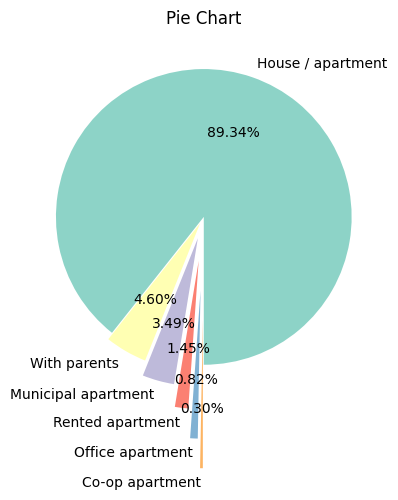

In [36]:
create_pie_plot(cc_train_copy, 'accommodation')

### 3.7 **Annual Income**

In [37]:
gen_info_feat(cc_train_copy, 'annual_income')

Description:
count      7767.00
mean     181047.38
std       98773.14
min       27000.00
25%      112500.00
50%      157500.00
75%      225000.00
max     1575000.00
Name: annual_income, dtype: float64
**************************************************
Data type: float64


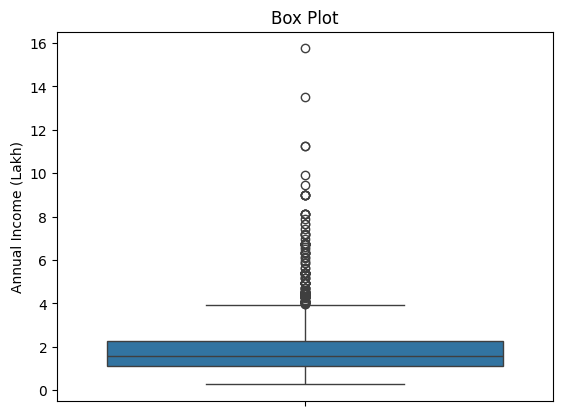

In [38]:
create_boxplot(cc_train_copy, 'annual_income')

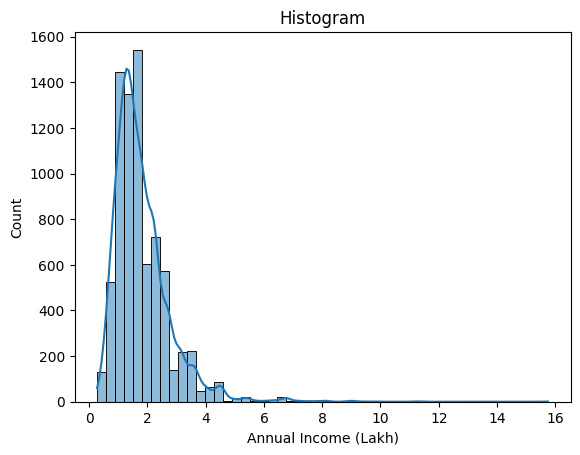

In [39]:
create_hist_plot(cc_train_copy, 'annual_income')

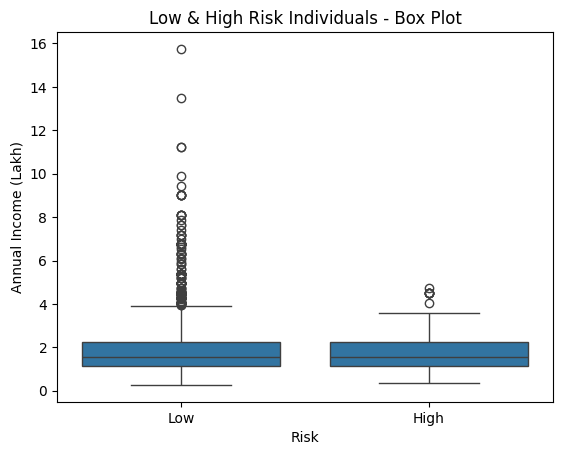

In [40]:
low_high_risk_boxplot(cc_train_copy, 'annual_income')

### 3.8 **Job title**

In [41]:
gen_info_feat(cc_train_copy, 'job_title')

Description:
count         5384
unique          18
top       Laborers
freq          1379
Name: job_title, dtype: object
**************************************************
Data type: object
**************************************************
                       Count  Frequency (%)
job_title                                  
Laborers                1379          25.61
Sales staff              767          14.25
Core staff               701          13.02
Managers                 632          11.74
Drivers                  506           9.40
High skill tech staff    301           5.59
Accountants              233           4.33
Medicine staff           233           4.33
Security staff           147           2.73
Cooking staff            146           2.71
Cleaning staff           115           2.14
Private service staff     68           1.26
Low-skill Laborers        43           0.80
Secretaries               35           0.65
Waiters/barmen staff      31           0.58
HR staff    

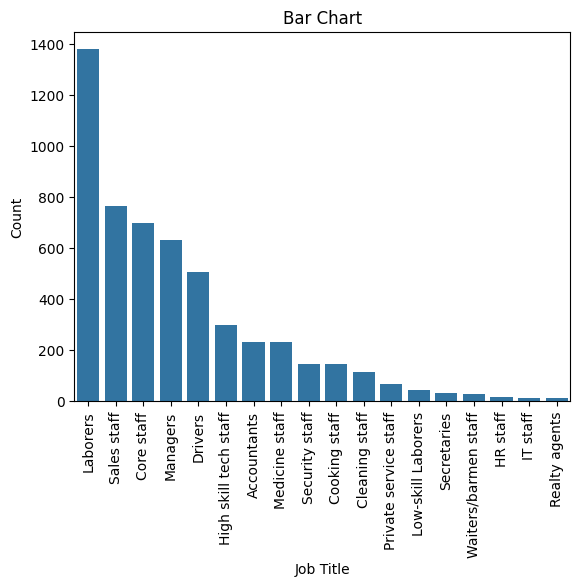

In [42]:
create_bar_plot(cc_train_copy, 'job_title')

### 3.9 **Occupation**

In [43]:
gen_info_feat(cc_train_copy, 'occupation')

Description:
count        7767
unique          5
top       Working
freq         3947
Name: occupation, dtype: object
**************************************************
Data type: object
**************************************************
                      Count  Frequency (%)
occupation                                
Working                3947          50.82
Commercial associate   1847          23.78
Pensioner              1382          17.79
State servant           589           7.58
Student                   2           0.03


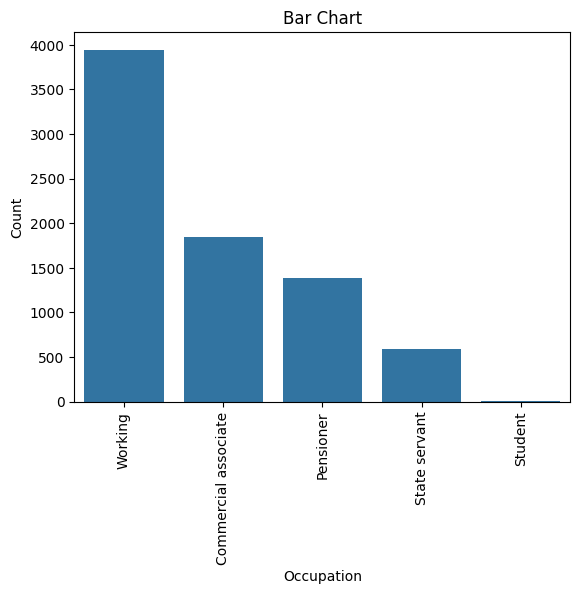

In [44]:
create_bar_plot(cc_train_copy, 'occupation')

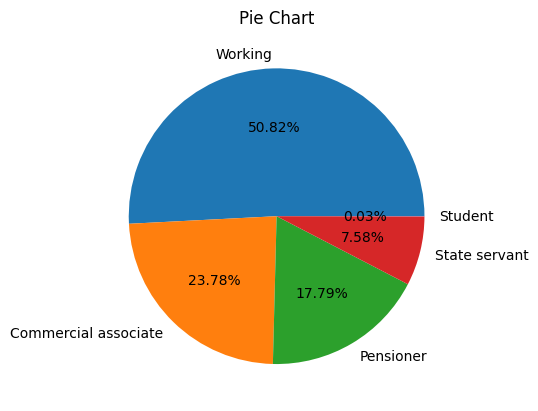

In [45]:
create_pie_plot(cc_train_copy, 'occupation')

### 3.10 **Education**

In [46]:
gen_info_feat(cc_train_copy, 'education')

Description:
count                              7767
unique                                5
top       Secondary / secondary special
freq                               5400
Name: education, dtype: object
**************************************************
Data type: object
**************************************************
                               Count  Frequency (%)
education                                          
Secondary / secondary special   5400          69.52
Higher education                1969          25.35
Incomplete higher                297           3.82
Lower secondary                   95           1.22
Academic degree                    6           0.08


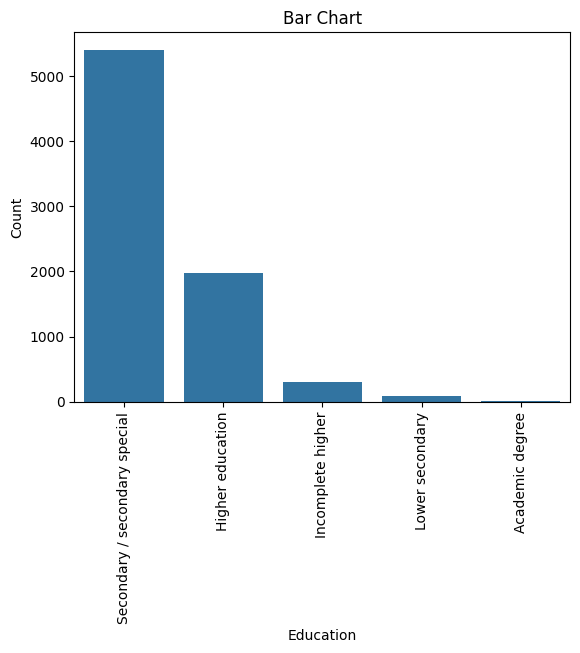

In [47]:
create_bar_plot(cc_train_copy, 'education')

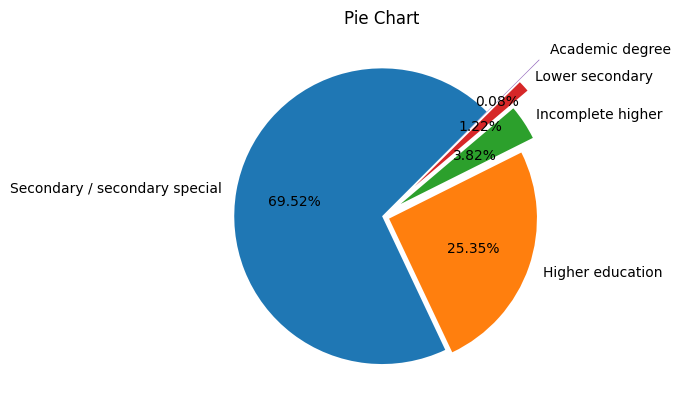

In [48]:
create_pie_plot(cc_train_copy, 'education')

### 3.11 **Employment Duration (Years)**

In [49]:
gen_info_feat(cc_train_copy, 'employment_duration')

Description (Years):
count   6397.00
mean       6.82
std        6.30
min        0.18
25%        2.36
50%        4.94
75%        9.16
max       43.02
Name: employment_duration, dtype: float64
**************************************************
Data type:int64


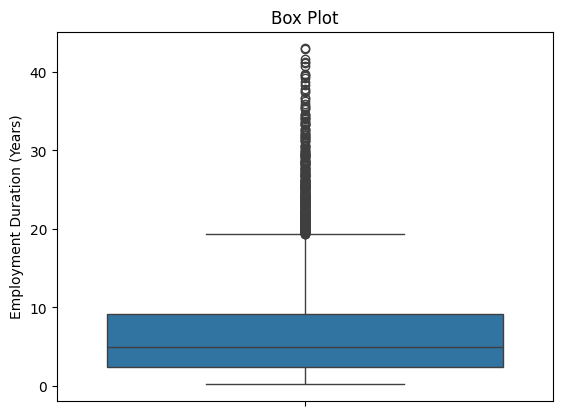

In [50]:
create_boxplot(cc_train_copy, 'employment_duration')

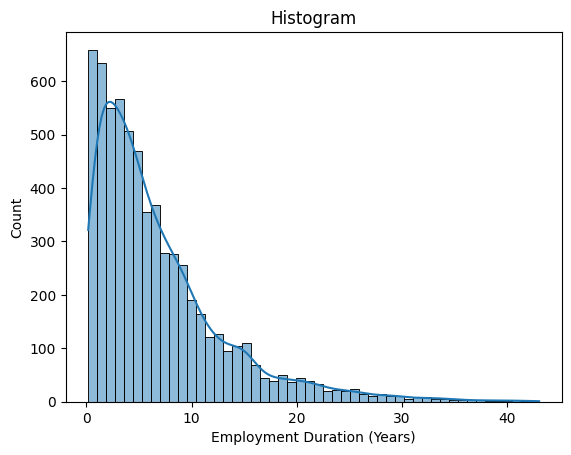

In [51]:
create_hist_plot(cc_train_copy, 'employment_duration')

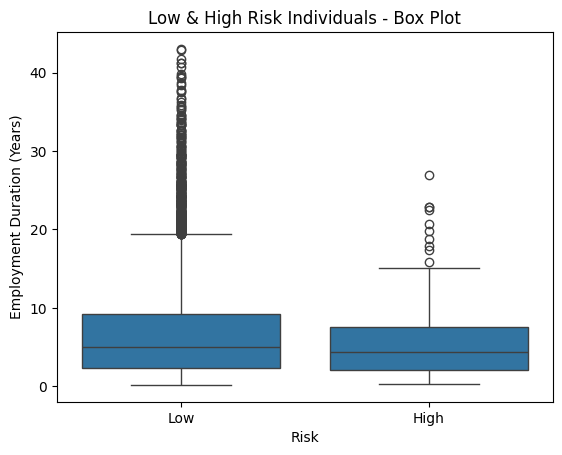

In [52]:
low_high_risk_boxplot(cc_train_copy, 'employment_duration')

### 3.12 **Own Car**

In [53]:
gen_info_feat(cc_application_df, 'owns_car')

Description:
count     9709
unique       2
top          N
freq      6139
Name: owns_car, dtype: object
**************************************************
Data type: object
**************************************************
          Count  Frequency (%)
owns_car                      
N          6139          63.23
Y          3570          36.77


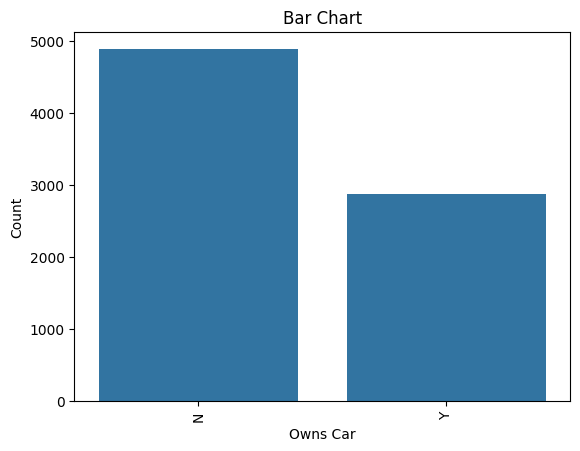

In [54]:
create_bar_plot(cc_train_copy, 'owns_car')

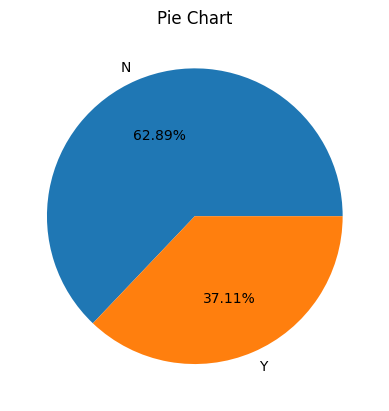

In [55]:
create_pie_plot(cc_train_copy, 'owns_car')

### 3.13 **Own Property**

In [56]:
gen_info_feat(cc_train_copy, 'owns_property')

Description:
count     7767
unique       2
top          Y
freq      5220
Name: owns_property, dtype: object
**************************************************
Data type: object
**************************************************
               Count  Frequency (%)
owns_property                      
Y               5220          67.21
N               2547          32.79


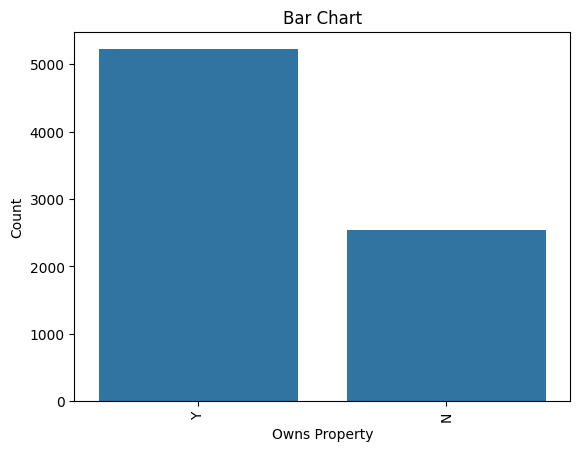

In [57]:
create_bar_plot(cc_train_copy, 'owns_property')

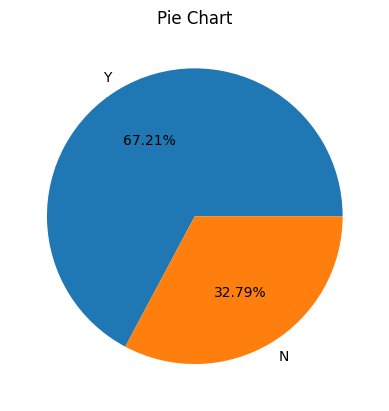

In [58]:
create_pie_plot(cc_train_copy, 'owns_property')

### 3.14 **Has Work Phone**

In [59]:
gen_info_feat(cc_train_copy, 'has_work_phone')

Description:
count   7767.00
mean       0.22
std        0.41
min        0.00
25%        0.00
50%        0.00
75%        0.00
max        1.00
Name: has_work_phone, dtype: float64
**************************************************
Data type: int64
**************************************************
                Count  Frequency (%)
has_work_phone                      
0                6060          78.02
1                1707          21.98


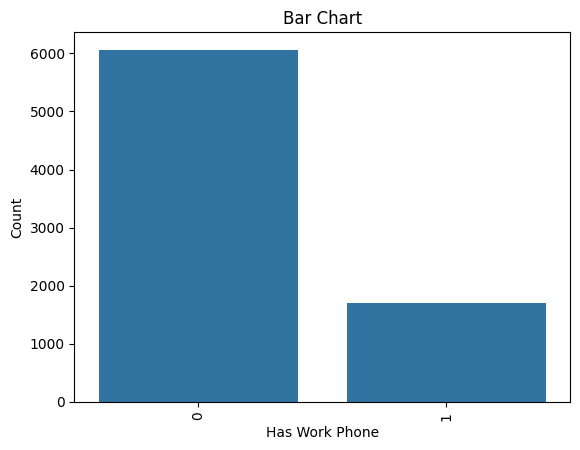

In [60]:
create_bar_plot(cc_train_copy, 'has_work_phone')

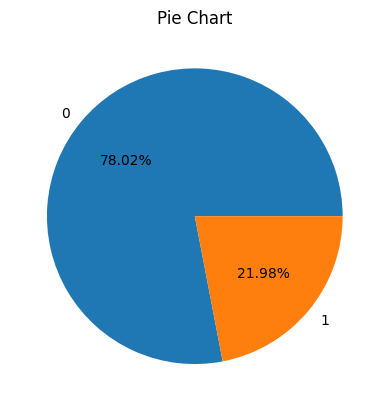

In [61]:
create_pie_plot(cc_train_copy, 'has_work_phone')

### 3.15 **Has Mobile**

In [62]:
gen_info_feat(cc_train_copy, 'has_mobile')

Description:
count   7767.00
mean       1.00
std        0.00
min        1.00
25%        1.00
50%        1.00
75%        1.00
max        1.00
Name: has_mobile, dtype: float64
**************************************************
Data type: int64
**************************************************
            Count  Frequency (%)
has_mobile                      
1            7767         100.00


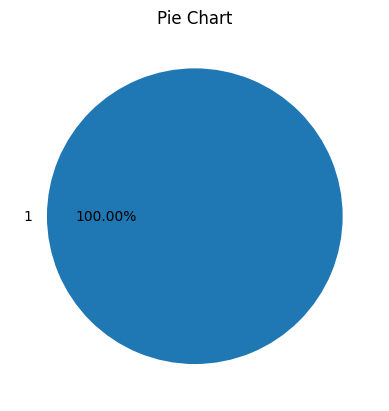

In [63]:
create_pie_plot(cc_train_copy, 'has_mobile')

### 3.16 **Has Phone**

In [64]:
gen_info_feat(cc_train_copy, 'has_phone')

Description:
count   7767.00
mean       0.29
std        0.45
min        0.00
25%        0.00
50%        0.00
75%        1.00
max        1.00
Name: has_phone, dtype: float64
**************************************************
Data type: int64
**************************************************
           Count  Frequency (%)
has_phone                      
0           5517          71.03
1           2250          28.97


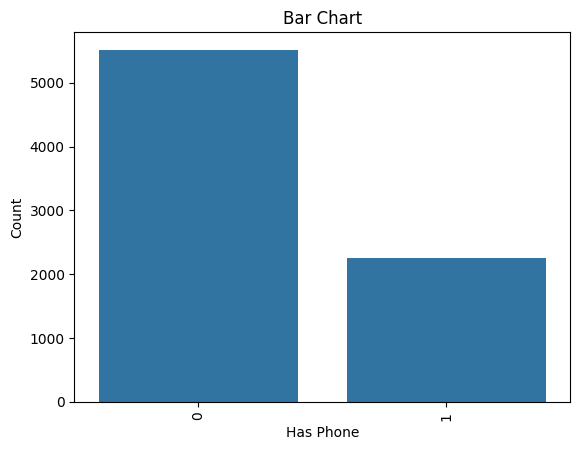

In [65]:
create_bar_plot(cc_train_copy, 'has_phone')

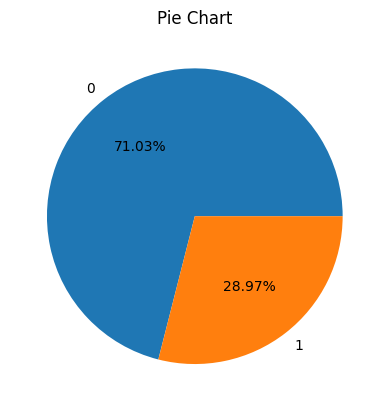

In [66]:
create_pie_plot(cc_train_copy, 'has_phone')

### 3.17 **Has Email**

In [67]:
gen_info_feat(cc_train_copy, 'has_email')

Description:
count   7767.00
mean       0.09
std        0.28
min        0.00
25%        0.00
50%        0.00
75%        0.00
max        1.00
Name: has_email, dtype: float64
**************************************************
Data type: int64
**************************************************
           Count  Frequency (%)
has_email                      
0           7085          91.22
1            682           8.78


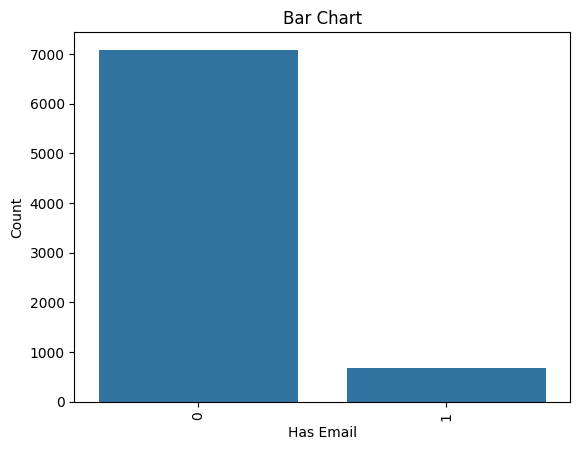

In [68]:
create_bar_plot(cc_train_copy, 'has_email')

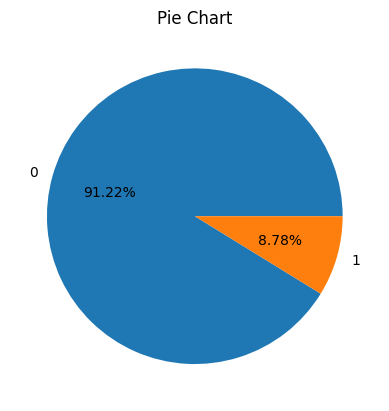

In [69]:
create_pie_plot(cc_train_copy, 'has_email')

### 3.18 **Account Age (Months)**

In [70]:
gen_info_feat(cc_train_copy, 'account_age_(months)')

Description:
count   7767.00
mean      27.35
std       16.60
min        0.00
25%       13.00
50%       26.00
75%       41.00
max       60.00
Name: account_age_(months), dtype: float64
**************************************************
Data type: int64


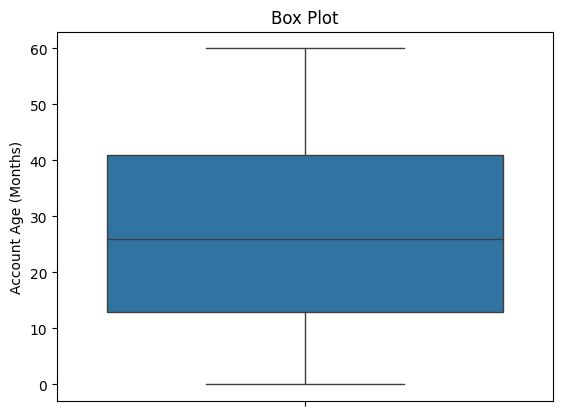

In [71]:
create_boxplot(cc_train_copy, 'account_age_(months)')

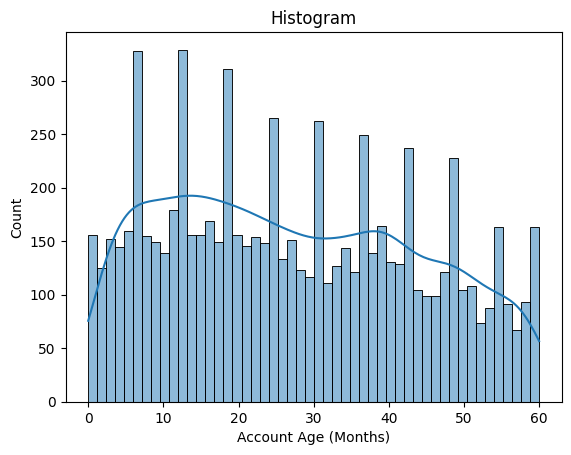

In [72]:
create_hist_plot(cc_train_copy, 'account_age_(months)')

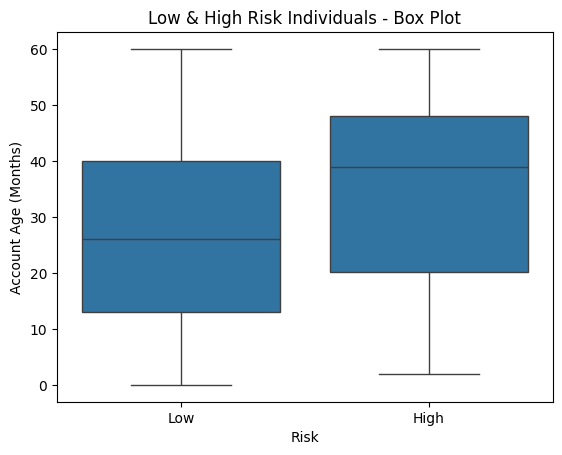

In [73]:
low_high_risk_boxplot(cc_train_copy, 'account_age_(months)')

### 3.19 **Is Risky (Target Variable)**

In [74]:
gen_info_feat(cc_train_copy, 'is_risky')

Description:
count   7767.00
mean       0.02
std        0.14
min        0.00
25%        0.00
50%        0.00
75%        0.00
max        1.00
Name: is_risky, dtype: float64
**************************************************
Data type: int64
**************************************************
          Count  Frequency (%)
is_risky                      
0          7605          97.91
1           162           2.09


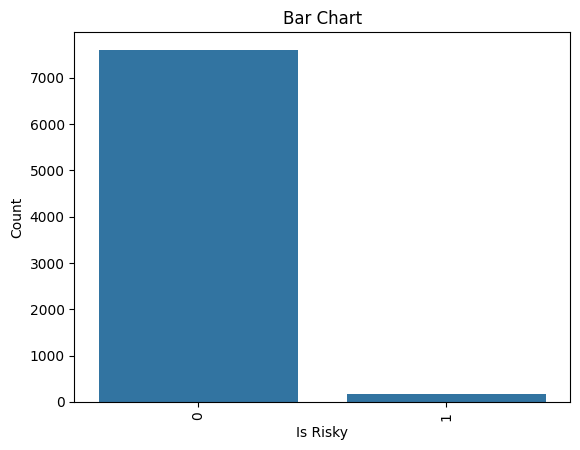

In [75]:
create_bar_plot(cc_train_copy, 'is_risky')

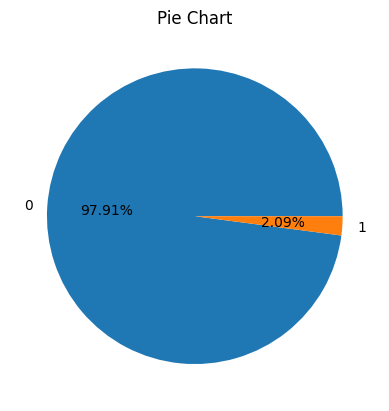

In [76]:
create_pie_plot(cc_train_copy, 'is_risky')